In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

from lstm_utils.utils import plot_confusion_matrix

/home/cybertech/tomekg/NLP_learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset('emotion')

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
model_chkpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_chkpt)
model = AutoModel.from_pretrained(model_chkpt).to('cuda')

In [5]:
def tokenize_batch(batch, tokenizer=tokenizer):
    return tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt')

ds = ds.map(tokenize_batch, batched=True, batch_size=None)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 49276.35 examples/s]


In [6]:
print(ds['train'][0])

{'text': 'i didnt feel humiliated', 'label': 0, 'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


In [7]:
ds.set_format('pytorch')

In [8]:
def extract_hidden_states(batch, model=model, model_input_names=tokenizer.model_input_names, device='cuda'):
    inputs = {k: v.to(device) for k, v in batch.items() if k in model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {'last_hidden_state': last_hidden_state[:,0].cpu().numpy()} # cls hidden state

ds = ds.map(extract_hidden_states, batched=True, batch_size=32)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 4305.56 examples/s]


In [9]:
ds['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'last_hidden_state']

In [10]:
X_train = np.array(ds['train']['last_hidden_state'])
y_train = np.array(ds['train']['label'])
X_test = np.array(ds['test']['last_hidden_state'])
y_test = np.array(ds['test']['label'])

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16000, 768), (16000,), (2000, 768), (2000,))

In [12]:
def reduce_dim_umap(X):
    reducer = umap.UMAP(n_components=5)
    X_scaled = StandardScaler().fit_transform(X)
    return reducer.fit_transform(X_scaled)

X_train_reduced = reduce_dim_umap(X_train)

/home/cybertech/tomekg/NLP_learning/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [13]:
df_train_reduced = pd.DataFrame(
    data=X_train_reduced, 
    columns=[f'component_{n}' for n in range(5)]
    )
df_train_reduced['label'] = ds['train']['label'].tolist()
df_train_reduced.head()

,component_0,component_1,component_2,component_3,component_4,label
0,2.766662,3.447841,6.538432,4.646395,8.542848,0
1,-2.085776,3.966758,10.391965,4.015772,4.520846,0
2,4.429896,4.273765,7.635953,5.174756,9.530114,3
3,-2.263433,4.527305,10.240788,5.340192,5.543682,2
4,-2.219372,4.958489,10.888474,4.960525,5.142501,3


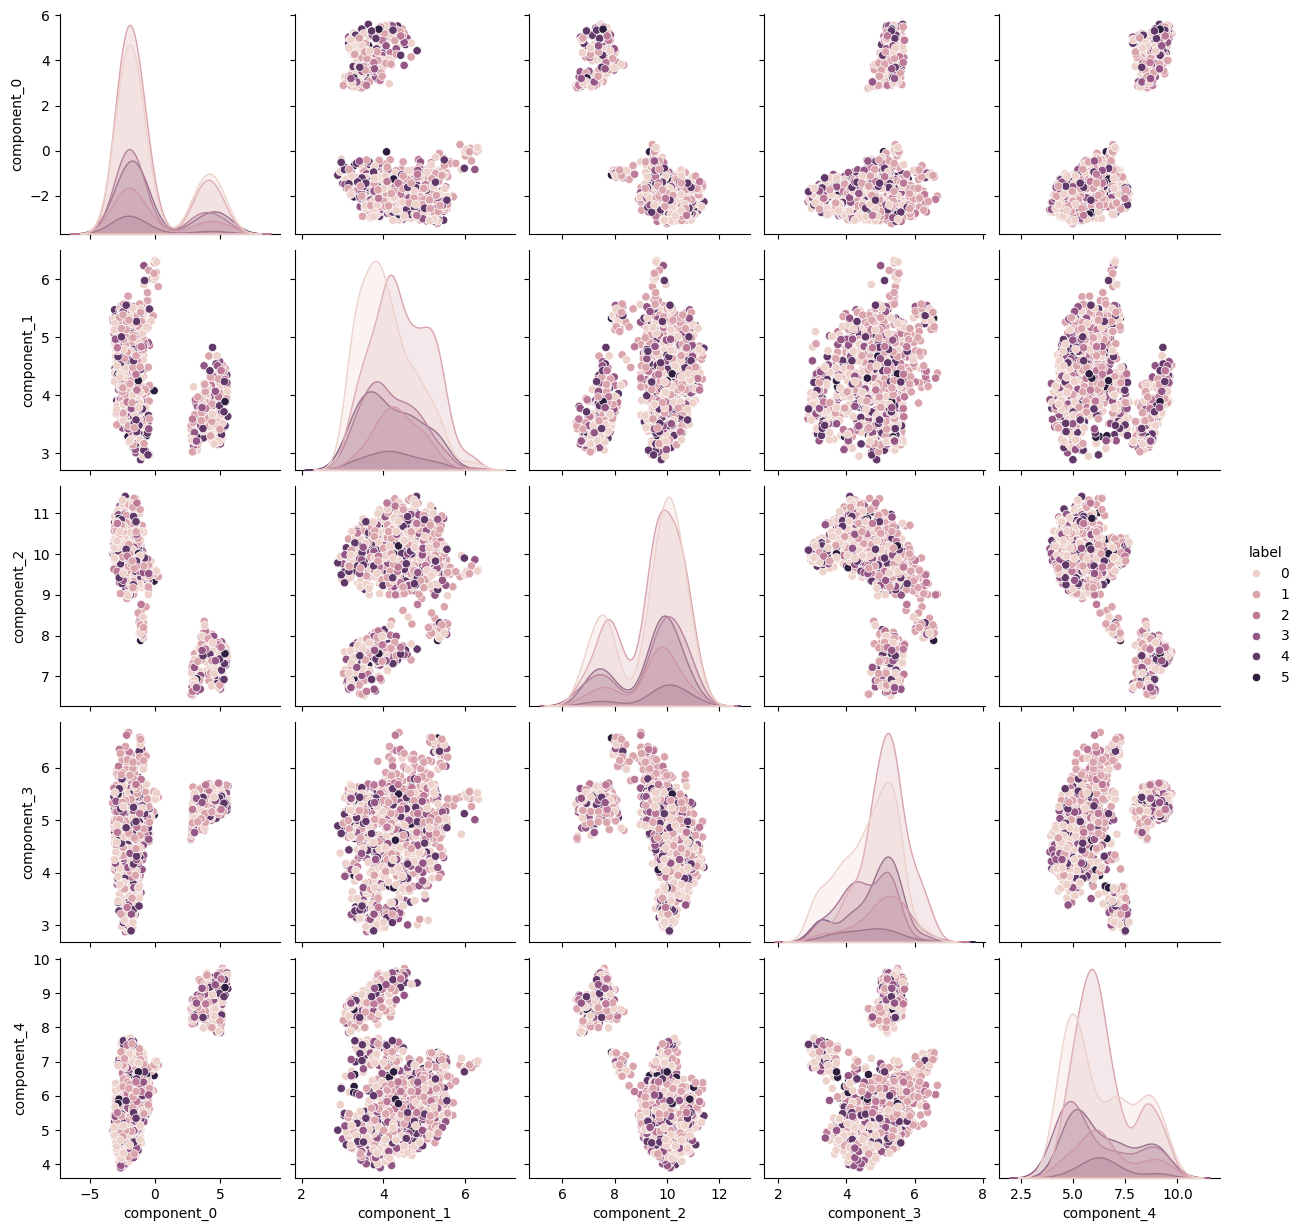

In [14]:
sns.pairplot(df_train_reduced.sample(1000), hue='label')
plt.show()

In [15]:
def train_test_simple_clf(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred_test = model.predict(X_test)
    plot_confusion_matrix(y_test, pred_test)
    return {'f1_macro': f1_score(y_test, pred_test, average='macro'), 
            'f1_micro': f1_score(y_test, pred_test, average='micro'),
            'accuracy': accuracy_score(y_test, pred_test)}

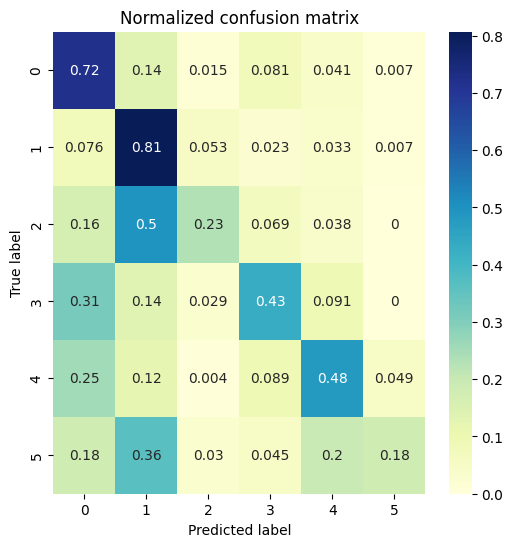

{'f1_macro': 0.49236451691707805, 'f1_micro': 0.627, 'accuracy': 0.627}

In [16]:
logistic_regression = LogisticRegression(max_iter=3000)
results_logistic_regression = train_test_simple_clf(
    model=logistic_regression,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)
results_logistic_regression

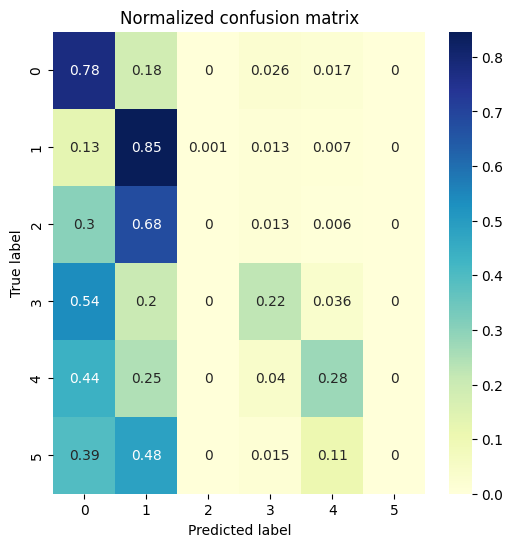

{'f1_macro': 0.3429075862036604, 'f1_micro': 0.5805, 'accuracy': 0.5805}

In [17]:
svm = SVC()
results_svm= train_test_simple_clf(
    model=svm,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)
results_svm